## Optimal transport as a statistical learning problem

### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.style.use("science")
import math
import matplotlib as mpl
from random import shuffle
import pandas as pd

### Optimal transport between two gaussians

Let
- $(\Omega_X, F_X, \mu)$ and $(\Omega_Y, F_Y, \nu)$ be two probability spaces
- $X:\Omega_X \rightarrow \mathbb{R}$ and $Y:\Omega_X \rightarrow \mathbb{R}$ be two random variables

**Experimental data**

In [2]:
data = pd.read_csv("../datasets/gaussians.csv")

In [3]:
mu = data["x"]
nu = data["y"]
n = data.shape[0]

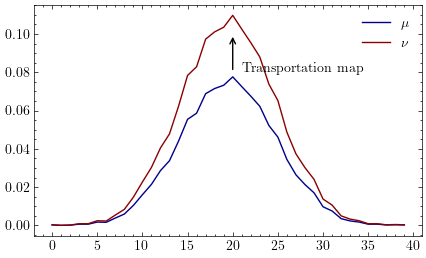

In [4]:
fig, ax = plt.subplots(figsize = (5, 3))
ax.plot(mu, color = "darkblue", label = r"$\mu$")
ax.plot(nu, color = "darkred", label = r"$\nu$")
ax.annotate("", xy=(20, 0.1), xytext=(20,0.08), arrowprops = dict(arrowstyle="->"))
ax.annotate("Transportation map", xy=(21, 0.1), xytext=(21, 0.08))
plt.legend()
plt.show()

**Transportation map**

In [5]:
def fill_poly(ax, f, a, b, label = "", color = "black"):
    idx_x = range(a, b + 1)
    idx_y = f[idx_x]
    idx_poly = [(a, 0), *zip(idx_x, idx_y), (b,0)]
    poly = mpl.patches.Polygon(idx_poly, color = "silver")
    ax.add_patch(poly)
    ax.annotate(label, ((a+b)/2, f[(a+b)//2]/2), color = color)

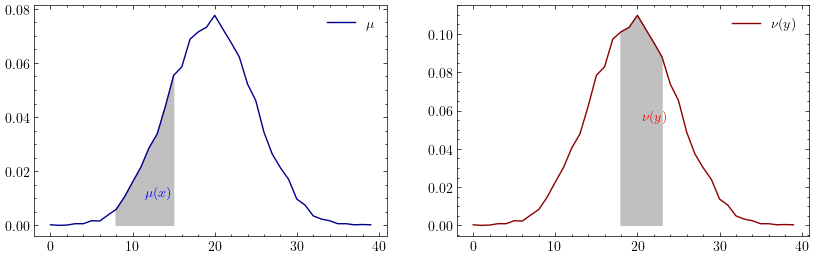

In [6]:
fig, axes = plt.subplots(1, 2, figsize = (10, 3))

axes[0].plot(mu, color = "darkblue", label = r"$\mu$")
fill_poly(axes[0], mu, 8, 15, r"$\mu(x)$", "blue")
axes[0].legend()

axes[1].plot(nu, color = "darkred", label = r"$\nu(y)$")
fill_poly(axes[1], nu, 18, 23, r"$\nu(y)$", "red")
axes[1].legend()
plt.show()

We want to find a transportation plan $T$ such that $\nu(y)=T(\mu(x))$ for each $x,y \in X \times Y$

If the $x_i \sim \mu$ and $y_i \sim \nu$, then we have a set 
${(x_1, y_1), ..., (x_n, y_n)} \sim X \times Y$

We want to find a function (transportation map) $T: X \rightarrow Y$ that maps each $x_i$ to $y_i$

Such function $T_{\#}(\mu)=\nu$ is called the push-forward measure of $\nu$

**Cost function**

$c_T(x,y) = d(x, y)$ is the cost of transporting $x$ to $y$

**Risk minimization**

The expected risk is 

$$
R_T = \int_{X \times Y} c_T(x, y) d\gamma(x,y) : \gamma \in \Gamma(x,y)
$$

**Empirical risk minimization**

Given that the distribution $\gamma(x, y)$ is unknown, 
we can use the empirical risk minimization principle

$$
R_{emp}^T = \dfrac{1}{N} \sum_{i=1}^{N} c_T(x_i, y_i)
$$

### Finding the optimal transport plan

**Candidate push forward measure**

We map each $x_i$ with an affine map $a x_i + b$

The transportation map is 

$$
T(x) = a * x + b : A \in \mathbb{R}^{n \times n}, b \in \mathbb{R}^{n}
$$

for a given $x_i$ we have 
$T(x_i) = a * x_i + b_i : a_i \in \mathbb{R}, b_i \in \mathbb{R}$

**Candidate cost function**

$$
c_T(x, y) = (y_i - T(x_i))^2 = (y_i - a*x_i - b)^2
$$

In [7]:
m = 100
ct = np.zeros((m, m))
at = np.linspace(-2, 2, m)
bt = np.linspace(-2, 2, m)
for i in range(m):
    for j in range(m):
        ct[i,j] = np.sum(0.5 * (nu - mu * at[i] - bt[j])**2)

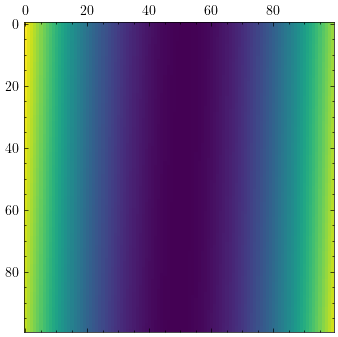

In [8]:
plt.matshow(ct)
plt.show()

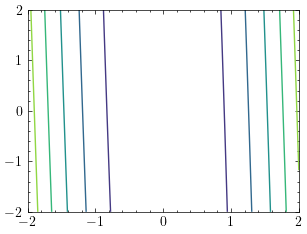

In [9]:
plt.contour(at, bt, ct)
plt.show()

**Empirical risk**

$$
R_{emp}^T = \dfrac{1}{2N} \sum_{i=1}^{N} (y_i - T(x_i))^2 =
    \dfrac{1}{2N} \sum_{i=1}^{N} (y_i - a * x_i - b)^2
$$

**Gradient of the risk**

$$
\dfrac{\partial R_{emp}^{T}}{\partial a} = \dfrac{2}{N} \sum_{i=1}^{N} x_i (a * x_i + b - y_i)
$$

$$
\dfrac{\partial R_{emp}^{T}}{\partial b} = \dfrac{2}{N} \sum_{i=1}^{N} (a*x_i + b - y_i)
$$

**Solve the learning problem with gradient descent**

In [10]:
def cost(a, b):
    return np.sum(0.5 * (nu - a*mu - b)**2)

In [11]:
def grad(a, b):
    da = 2/n * np.sum(mu * (a * mu + b - nu))
    db = 2/n * np.sum(a * mu + b - nu)
    return (da, db)

In [12]:
a = 1.0
b = 0.
eps=1e-5
lr = 0.9
max_iter = 10000
hist = []
loss0 = 0.
for epoch in range(max_iter):
    da, db = grad(a, b)
    a = a - lr * da
    b = b - lr * db
    loss = cost(a,b)
    if abs(loss0 - loss) < eps:
        break
    hist += [(a,b)]
print("Epoch {} : Loss {}".format(epoch, loss))
print("Optimal values a = {} and b = {}".format(a, b))

Epoch 2123 : Loss 9.98349702183176e-06
Optimal values a = 1.3878961908294258 and b = 0.0006584085211596733


**Visual checking**

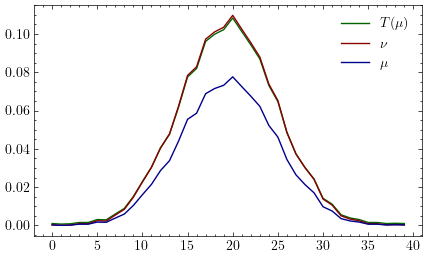

In [13]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(a * mu + b, color = "darkgreen", label = r"$T(\mu)$")
ax.plot(nu, color = "darkred", label = r"$\nu$")
ax.plot(mu, color = "darkblue", label = r"$\mu$")
plt.legend()
plt.show()